# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 21, alternate_sign=False, strip_accents='unicode', analyzer='word', token_pattern=r'\b[^\d\W]+\b')
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=81)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 2097152)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [8]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 5218, 'TN': 4843, 'FP': 5115, 'FN': 4824, 'Accuracy': 0.50305, 'Precision': 0.5049840317429595, 'Recall': 0.5196176060545709, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [9]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=1)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10011, 'TN': 9935, 'FP': 23, 'FN': 31, 'Accuracy': 0.9973, 'Precision': 0.9977077935020929, 'Recall': 0.9969129655447122, 'desc': 'svm_train'}


### MODEL: logistic regression

In [10]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10042, 'TN': 9958, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 9705, 'TN': 9840, 'FP': 118, 'FN': 337, 'Accuracy': 0.97725, 'Precision': 0.9879873765652041, 'Recall': 0.966440948018323, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [12]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10042, 'TN': 9958, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [13]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10005, 'TN': 9950, 'FP': 8, 'FN': 37, 'Accuracy': 0.99775, 'Precision': 0.9992010386497553, 'Recall': 0.9963154750049791, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/johnoutwater/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 10042, 'Neg': 9958, 'TP': 8434, 'TN': 2672, 'FP': 7286, 'FN': 1608, 'Accuracy': 0.5553, 'Precision': 0.5365139949109414, 'Recall': 0.8398725353515236, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

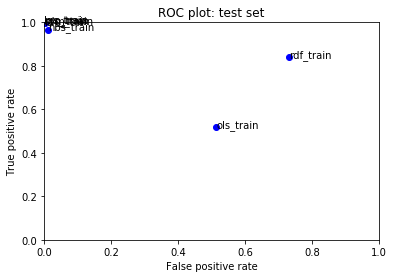

In [15]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [16]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [17]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
15
It has very bad acting. Bad story lines. Bad characters. You should never see this show If you see it on. TURN IT OFF. Or you be cringing for the next 30 minutes. It should have never been aired. It's not great. You should never see it. NEVER EVER EVER. So now, if you ever wanna watch this show, please don't. Turn to the THE CW for Smallville. Or Disney Channel for Hannah Montana, Wizards Of Waverly Place, or Nick for Drake & Josh, Those are much better family shows. So believe me on this, I've watched it before. and It is honestly, and I say Honestly, the worst show I've ever seen, and I've seen a lot of TV. So do me a favor, and never watch this show.
* * * * * * * * * 
50
The storyline is absurd and lame,also sucking are performances and the dialogue, is hard to keep your Eyes open. I advise you to have a caffeine-propelled friend handy to wake you in time for a couple Gore-effects.Why they bring Alcatraz in?In this case,becomes increasingly difficult

3164
This movie was terrible!I rented it not knowing what to expect.I watched the 1st 5 minutes and the movie and knew it was a bomb.The acting was bad and there was no plot.The monster is soooooo fake.It growls and its mouth doesnt move.Also why would they have a doctor playing a xylophone to kill the monster.Just plain bad don't even waste your time.(1 out of 10)
* * * * * * * * * 
3236
I've seen plenty of Sci-Fi Channel Original movies ever since I started watching them back in 2002 (My first one was Sabretooth - which actually is one of the more entertaining Sci-Fi Channel features in my opinion). Their quality varies. Some of them are average but decent (Sabretooth, Dragon Fighter, Never Cry Werewolf, Swamp Devil), some are laughably bad, and then there are some that are truly terrible. Raptor Planet lies in the latter. <br /><br />Raptor Planet, a loose sequel to the 2004 Sci-Fi Channel Original Raptor Island, is a barely watchable mess of a film with truly horrid acting and lazy

* * * * * * * * * 
6080
What a dreadful film this is. The only reason you would want to sit through this mess is the pleasurable sight of Miss Eleniak. The painful overacting of Mr McNamara, which became embarrassing at times, ruined what might have been a reasonable film if the correct actors had been cast. Mr McNamara is no Tom Cruise, the actor he obviously wants to be.
* * * * * * * * * 
6112
This movie is the worst movie i have ever seen... it is humorous how bad it is.. the entire time i was watching it i half expected music to start and the doctor starts dancing..(i've seen porno's with a better plot) When the raptor was trying to get in the door i think someone was throwing a plastic doll against the door from about 2 feet away. But as i said it is so bad you need to watch it so that you can see just how bad it is me explaining it isn't going to do anything compared to if you watch it .. i don't recommend renting it but if it comes on TV watch it for about 30min just to see wha

9046
If there was a 0 stars rating i would gladly hand it out to this absolutely horrid pile of waste. The fact that the actual summary is perfectly fine and that if it had been made different it could have been brilliant only makes it worse. The basic task of locking up a group of people in an experiment chamber is fine, but WHERES THE EXPERIMENT? All i see is a bunch of unintelligent surfers and blondes chatting about music and culture i don't know or want to know about... The challenges are pathetic and silly. The whole point of reality TV is to show REALITY. If you set a 'challenge' don't make them play with exaggerated props of food and stereotypical cultural elements in 'friday night games'. make them do an actual challenge. And as for 'earning' prize money, thats fine, if they actually earnt it! These people are nuts. If only they would make the show better, the actual idea would be glorious. But that ain't gonna happen!
* * * * * * * * * 
9160
Black guy becomes rich white guy, 

11959
What a terrible film. It sucked. It was terrible. I don't know what to say about this film but DinoCrap, which I stole from some reviewer with a nail up his ass. AHAHAHAHAHHAHAHAHAHAHAHAHAHAHHAHAHAHAHAHAHAH!!!!!!!!!!!!!!!!!!! sigh.. It's not Roger Corman that I hate, it's this god-awful movie. Well, really? But what can you expect from a movie with Homoeric computer graphics. Which is another thing, the CGI sucked out loud; I hate this movie dreadfully. This is without a doubt the worst Roger Corman B-Movie, and probably the gayest B-Movie too. It's-it's--- DINOCRAP! I'm sorry, I must have offended some nerds in these moments. It's just an awful movie... 0/1,000
* * * * * * * * * 
11985
This is the worst movie I have ever seen in my entire life. The plot and message are horrible. There are too many mistakes in this movie that it's impossible to keep up. I don't even understand how this movie can get any nomination, let alone 2. Here's why: 1) Sam Lee portrays a angry/irrational d

15062
I have never seen a movie as bad as this. It is meant to be a \fun\" movie, but the only joke is at the start, and it is NOT funny. If you like this sort of movie, then you may just be able to give it a vote of 2. If it had the necessary votes, it would truly belong on the bottom 100.<br /><br />"
* * * * * * * * * 
15321
This was a truly bad film. The character \Cole\" played by Michael Moriarty was the biggest reason this flopped, the actor felt that conjuring up an unbelievably awkward southern drawl would make this character more evil, it didn't. After about 20 minutes I had wished for a speech therapist to make an appearance, this would have added some sincerity.<br /><br />- 1) badly acted - 2) unsympathetic characters - 3) razor thin plot line<br /><br />Yuck!<br /><br />"
* * * * * * * * * 
15351
A story of amazing disinterest kills \The Psychic\" over and over again. The characters and plot are completely uninteresting (as is Fulci's mad camera work, which is usually a r

17973
I only watched the first 30 minutes of this and what I saw was a total piece of crap. The scenes I saw were as bad as an Ed Wood movie. No, it was a hundred times WORSE. Ed Wood has the reputation of being the worst director ever but that's not true; the idiot who directed this junk is the WORST director ever.<br /><br />The American cop has a German accent! The \police station\" was a desk in a warehouse with a sign \"Police Station\" hanging on the wall. There is a fist fight where the punches clearly miss by about TEN FEET.<br /><br />This cop pulls women over, cuffs them and leads them to a warehouse. He tells his cop partner to wait in the car. Then he comes out of the warehouse carrying a duffel bag. The cop partner thinks maybe something is not right, that his partner might be a bad cop who is murdering these women, but he isn't sure if that is what's happening because - he's a moron! The dialog is totally stupid, the acting is awful, and the characters act in the stupides

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [18]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 1311, 'TN': 1220, 'FP': 1322, 'FN': 1147, 'Accuracy': 0.5062, 'Precision': 0.49791112799088494, 'Recall': 0.5333604556550041, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [19]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2206, 'TN': 2188, 'FP': 354, 'FN': 252, 'Accuracy': 0.8788, 'Precision': 0.86171875, 'Recall': 0.8974776240846216, 'desc': 'svm_test'}


### MODEL: logistic regression

In [20]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2074, 'TN': 2070, 'FP': 472, 'FN': 384, 'Accuracy': 0.8288, 'Precision': 0.8146111547525531, 'Recall': 0.8437754271765663, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [21]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 1866, 'TN': 1904, 'FP': 638, 'FN': 592, 'Accuracy': 0.754, 'Precision': 0.7452076677316294, 'Recall': 0.7591537835638731, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [22]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2071, 'TN': 2111, 'FP': 431, 'FN': 387, 'Accuracy': 0.8364, 'Precision': 0.8277378097521982, 'Recall': 0.8425549227013832, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [23]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2103, 'TN': 2285, 'FP': 257, 'FN': 355, 'Accuracy': 0.8776, 'Precision': 0.8911016949152543, 'Recall': 0.855573637103336, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [24]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2061, 'TN': 658, 'FP': 1884, 'FN': 397, 'Accuracy': 0.5438, 'Precision': 0.5224334600760456, 'Recall': 0.838486574450773, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

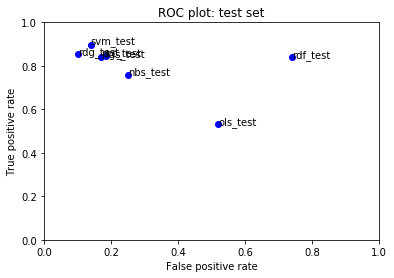

In [25]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [26]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=81, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 2097152)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Siz

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [27]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.44148


In [28]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [29]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [30]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation